# Self-guided Integrated Grandient Method for Attribution (SIGMA)

Below is sample code that will load in an image and model of choice and use the SIGMA method to produce an attribution map. For this example we use the basketball image and InceptionV3 model.

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from SIGMA import SIGMA_attribution, SIGMA_attribution_adaptive

2025-06-16 09:20:34.099977: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 09:20:34.118650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750062034.138320 3958510 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750062034.144473 3958510 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750062034.181029 3958510 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Load model and image to be explained

In this example we use InceptionV3

In [2]:
model = tf.keras.applications.InceptionV3(weights='imagenet')
preprocess_fn = tf.keras.applications.inception_v3.preprocess_input
target_size = (299,299) # The size of image the model expects

I0000 00:00:1750062039.826115 3958510 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
I0000 00:00:1750062039.826756 3958510 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22453 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
I0000 00:00:1750062039.827219 3958510 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22453 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:22:00.0, compute capability: 8.6
I0000 00:00:1750062039.827671 3958510 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22453 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:23:00.0, compute capability: 8.6
I0000 00:00:1750062039.828120 3958510 gpu_device.cc:2019

Choose an image to be explained - this example uses the goldfish image

I0000 00:00:1750062044.203172 3958510 cuda_dnn.cc:529] Loaded cuDNN version 90300


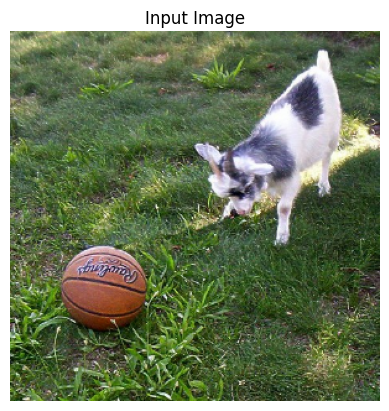

target class: 430
Predicted probability: 0.9957


In [3]:
# Finds directory where the current script is located
BASE_DIR = os.getcwd()

# Relative path to the image
IMAGE_PATH = os.path.join(BASE_DIR, "sample_images", "basketball.jpg")

raw_image = tf.io.read_file(IMAGE_PATH)
decoded_image = tf.image.decode_jpeg(raw_image, channels=3) #Decode image into a TensorFlow tensor
resized_image = tf.image.resize(decoded_image, target_size)

preprocessed = preprocess_fn(tf.expand_dims(tf.cast(resized_image, tf.float32), 0))
preds = model(preprocessed)

class_idx = int(np.argmax(preds[0]))
probability = float(preds[0][class_idx])

plt.imshow(resized_image.numpy().astype("uint8"))
plt.title("Input Image")
plt.axis('off')
plt.show()

print(f"target class: {class_idx}")
print(f"Predicted probability: {probability:.4f}")

### Run SIGMA attribution and visualise 

In [6]:
n_paths = 7 # Number of paths to average over
beta = 0.5 # Perturbation Magnitude
alpha = 0.5 # Step size
epsilon = 0.05 # Stopping criteria - softmax values below 0.01 increase computation time without adding to the attribution itself
target_class = class_idx

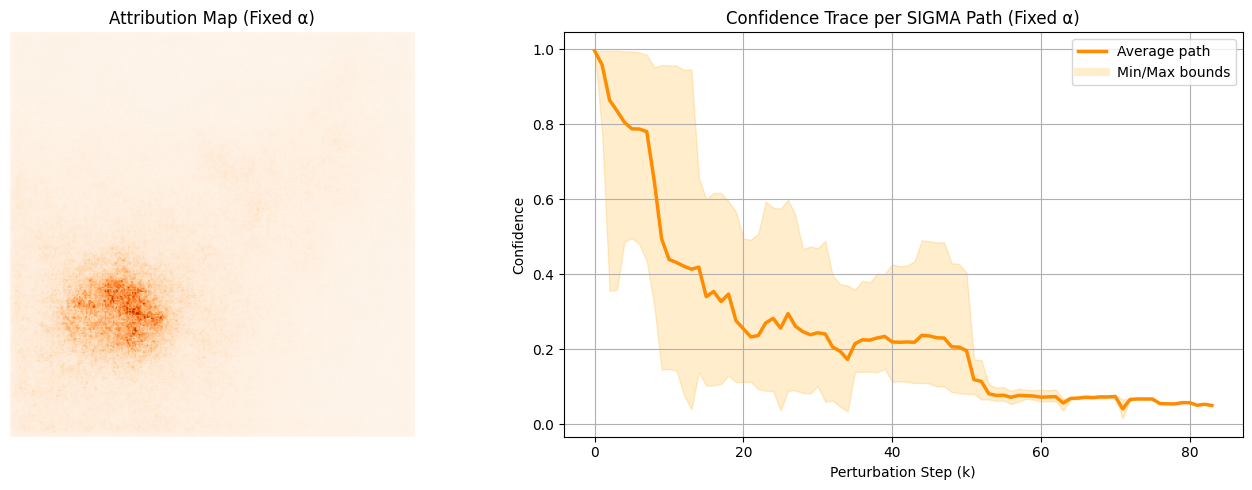

In [7]:
# Runs the SIGMA attribution with a constant step size 
average_attribution_map,all_confidences, final_img = SIGMA_attribution(
    model=model,
    image=resized_image.numpy(),
    target_class=target_class,
    n=n_paths,
    beta=beta,
    alpha=alpha,
    epsilon=epsilon,
    preprocess_fn=preprocess_fn
)


# For plotting all paths
def pad_confidence_curves(confidences):
    max_len = max(len(trace) for trace in confidences)
    return np.array([
        np.pad(trace, (0, max_len - len(trace)), constant_values=np.nan)
        for trace in confidences
    ])
padded_fixed = pad_confidence_curves(all_confidences.numpy())
mean_fixed = np.nanmean(padded_fixed, axis=0)
min_fixed = np.nanmin(padded_fixed, axis=0)
max_fixed = np.nanmax(padded_fixed, axis=0)
steps = np.arange(mean_fixed.shape[0])


# Visualises final attribution map and all SIGMA paths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Attribution Map
ax1.imshow(average_attribution_map.numpy(), cmap='Oranges')
ax1.set_title("Attribution Map (Fixed α)")
ax1.axis('off')

# Right: Confidence Curve with Bounds
ax2.plot(steps, mean_fixed, color='darkorange', linewidth=2.5, label='Average path')
ax2.fill_between(steps, min_fixed, max_fixed, color='orange', alpha=0.2, label='Min/Max bounds')
ax2.set_title("Confidence Trace per SIGMA Path (Fixed α)")
ax2.set_xlabel("Perturbation Step (k)")
ax2.set_ylabel("Confidence")
ax2.grid(True)


custom_lines = [
    Line2D([0], [0], color='darkorange', lw=2.5, label='Average path'),
    Line2D([0], [0], color='orange', lw=6, alpha=0.2, label='Min/Max bounds')
]
ax2.legend(handles=custom_lines)

plt.tight_layout()
plt.show()

Attribution for SIGMA with an adaptive step size calculated using the Barzilai–Borwein method leading to faster convergence - a suitable range for alpha still needs to be defined

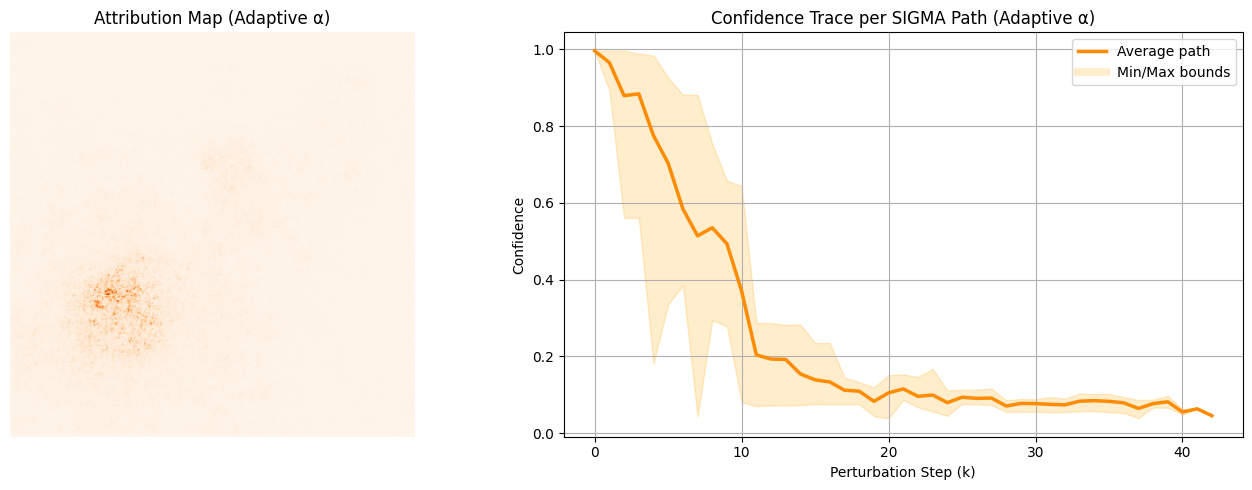

In [9]:
# Define a range for alpha - the adaptive alpha method will use the Barzilai–Borwein method to select the optimal alpha for this range - reducing convergence time
alpha_range = [0.5,1.0] 

# Runs the SIGMA attribution with an adaptive step size
average_attribution_map,all_confidences, final_img = SIGMA_attribution_adaptive(
    model=model,
    image=resized_image.numpy(),
    target_class=target_class,
    n=n_paths,
    alpha_range = alpha_range,
    beta=beta,
    epsilon=epsilon,
    preprocess_fn=preprocess_fn
)


# For plotting all paths 
def pad_confidence_curves(confidences):
    max_len = max(len(trace) for trace in confidences)
    return np.array([
        np.pad(trace, (0, max_len - len(trace)), constant_values=np.nan)
        for trace in confidences
    ])   
padded_fixed = pad_confidence_curves(all_confidences.numpy())
mean_fixed = np.nanmean(padded_fixed, axis=0)
min_fixed = np.nanmin(padded_fixed, axis=0)
max_fixed = np.nanmax(padded_fixed, axis=0)
steps = np.arange(mean_fixed.shape[0])


# Visualises final attribution map and all SIGMA paths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Attribution Map
ax1.imshow(average_attribution_map.numpy(), cmap='Oranges')
ax1.set_title("Attribution Map (Adaptive α)")
ax1.axis('off')

# Right: Confidence Curve with Bounds
ax2.plot(steps, mean_fixed, color='darkorange', linewidth=2.5, label='Average path')
ax2.fill_between(steps, min_fixed, max_fixed, color='orange', alpha=0.2, label='Min/Max bounds')
ax2.set_title("Confidence Trace per SIGMA Path (Adaptive α)")
ax2.set_xlabel("Perturbation Step (k)")
ax2.set_ylabel("Confidence")
ax2.grid(True)

custom_lines = [
    Line2D([0], [0], color='darkorange', lw=2.5, label='Average path'),
    Line2D([0], [0], color='orange', lw=6, alpha=0.2, label='Min/Max bounds')
]
ax2.legend(handles=custom_lines)

plt.tight_layout()
plt.show()